## JONES MODEL

## Table of Contents

- [Problem Statement](#Problem-Statemet)
- [Executive Summary](#Executive-Summary)
- [Data Dictionary](#Data-Dictionary)
- [Loading Data](#Loading-Data)
- [Data Cleaning](#Data-Cleaning)
- [EDA](#EDA)
- [Feature Engineering](#Feature-Engineering)
- [Model Preparation](#Model-Preparation)
- [Model Selection](#Model-Selection)
- [Conclusion](#Model-Selection)
- [Recommendations](#Reccomendations)
- [Resources](#Resources)



## Problem Statement

TNA / ATA = β0 + β1(1/ATA) + β2(ΔSales – ΔRec / ATA) + β3(GPPE / ATA ) + ε TNA= Total net accruals NOA= Net operating accruals ATA = Average total assets ΔSales = Change in sales ΔRec= Change in accounts receivable GPPE = Gross PP&E

During election time, we see the amount of restatements on accruals go up for company, Accrual accounting is required by GAAP and companies have to spend loads of money to adapt to these standards. I want to create a linear model to predict the amount of accruals for a company, so we can plan the audit process accordingly. I want to use R2 as my metric to deermine Jones Model is used to prodect the total net accruals for a company. This model is going to input variables from 2016 Q1-Q4 data into the regression model. After We create the model, we are going to train the model on a prior period data. Then we are going to use the model to test it on the next period(2017 Q3).



# Executive Summary

My approach was to first decide what platforms have this data available. I found that the data is readily avaliable on Kaggle.From initial data review, I hypothesized that the 'Overall Qual', 'TotalSqFt', 'Gr Liv Area', 'Exter Qual', 'Kitchen Qual' variables would have the most influence over sales price. The abundance of variables, forced me to dive deeper into the data in order to find the most optimal combinations in order to find the highest scoring model. We want a high majority of the data to be explained by our model. 


EDA helped me not only set up a preprocessing plan for our model, but helped me understand the health of the data One example was that “Total Square feet” showed up high on the correlation heat map, meaning that this variable will be useful in predicting sale price. For preprocessing, I chose to fill all null values wiht na, assuming that those values actually reperesented none of that type. I also created feature engineering for square feet, bathrooms, and porch square feet in order to simplify the model, so I could use those variables in the model.  For modeling, I chose to use linear regression and lasso regression because of the way it focuses on the relationship of features and our predicted variable(sale price). 

|Model|Type|Train R2|Testing R2|
|---|---|---|---|
|**Model 1**|*Linear*|.84|.84| 
|**Model 2**|*Linear*|.93|.94|
|**Model 3**|*Ridge*|.91|.88|
|**Model 4**|*Lasso*|.91|.88|

My approach to picking the best model, is by assessing the R2 Score. At first, I tried fitting a model with all variables, but decided that is overkill for our clients. I simplified the model by choosing the features with the highest correlations in predicting sale price. I will use Lasso regression to identify correlations close to 0, and remove those from the model. I will asses performance based on R^2 

## Data Dictionary

Refer to Kaggle for Data Description

- [Kaggle Data](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

## Loading Data

In [1]:
import pandas as pd
from sklearn import linear_model
from sklearn import linear_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore") # Shhhh


import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
RANDOM_STATE = 90210
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sm
import matplotlib.pyplot as plt

from math import sqrt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import mean_squared_error, f1_score
from sklearn import svm
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline


%matplotlib inline

Loading in 2016 Q1 data for 2015 numbers

In [2]:
num1 =  pd.read_csv('./data/2016q1/num.txt', sep = '\t', encoding="latin-1")
tag1 =  pd.read_csv('./data/2016q1/tag.txt', sep = '\t', encoding="latin-1")
pre1 =  pd.read_csv('./data/2016q1/pre.txt', sep = '\t', encoding="latin-1")
sub1 =  pd.read_csv('./data/2016q1/sub.txt', sep = '\t', encoding="latin-1")

## Data Cleaning

In [3]:
firstmerge1 = pd.merge(pre1, sub1, how = "left", on=['adsh'])   #left merge

secondmerge1 = pd.merge(firstmerge1, tag1, how= "left", on =['tag', 'version'])

thirdmerge1 = pd.merge(secondmerge1, num1, how = "left", on =['adsh', 'tag', 'version'])
sec_table2015 = thirdmerge1[['cik','adsh' , 'afs' , 'qtrs' , 'fy' , 'fp', 'tag', 'version', 'value' , 'ddate']].sort_values(['cik'])

In [4]:
Regression_2015 =  sec_table2015[(sec_table2015.tag == 'NetIncomeLoss')
                        | (sec_table2015.tag == 'NetCashProvidedByUsedInOperatingActivities')
                        | (sec_table2015.tag == 'SalesRevenueNet')
                        | (sec_table2015.tag == 'Assets')
                        | (sec_table2015.tag == 'AccountsReceivableNetCurrent')
                        | (sec_table2015.tag == 'PropertyPlantAndEquipmentNet')]
Regression_2015

,cik,adsh,afs,qtrs,fy,fp,tag,version,value,ddate
1110855,1750,0001104659-16-107128,1-LAF,1.0,2016.0,Q3,SalesRevenueNet,us-gaap/2015,4.028000e+08,20160229.0
1110854,1750,0001104659-16-107128,1-LAF,3.0,2016.0,Q3,SalesRevenueNet,us-gaap/2015,1.178500e+09,20150228.0
1110856,1750,0001104659-16-107128,1-LAF,3.0,2016.0,Q3,SalesRevenueNet,us-gaap/2015,1.204400e+09,20160229.0
741699,1750,0001104659-16-107128,1-LAF,0.0,2016.0,Q3,PropertyPlantAndEquipmentNet,us-gaap/2015,2.148000e+08,20150531.0
741700,1750,0001104659-16-107128,1-LAF,0.0,2016.0,Q3,PropertyPlantAndEquipmentNet,us-gaap/2015,2.224000e+08,20160229.0
...,...,...,...,...,...,...,...,...,...,...
734639,1667489,0001548123-16-000469,5-SML,0.0,2015.0,FY,PropertyPlantAndEquipmentNet,us-gaap/2015,4.463200e+04,20141231.0
166784,1667489,0001548123-16-000469,5-SML,0.0,2015.0,FY,Assets,us-gaap/2015,1.283508e+07,20141231.0
166785,1667489,0001548123-16-000469,5-SML,0.0,2015.0,FY,Assets,us-gaap/2015,1.432558e+07,20151231.0
734640,1667489,0001548123-16-000469,5-SML,0.0,2015.0,FY,PropertyPlantAndEquipmentNet,us-gaap/2015,2.187000e+04,20151231.0


In [5]:
Regression_2015.pivot_table(values='value', index=['tag', 'adsh','cik','ddate'], columns=['qtrs'])

qtrs                                                                        0.0    \
tag                          adsh                 cik     ddate                     
AccountsReceivableNetCurrent 0000002178-16-000064 2178    20141231.0  144434000.0   
                                                          20151231.0   71813000.0   
                             0000002488-16-000111 2488    20141231.0  818000000.0   
                                                          20151231.0  533000000.0   
                             0000003545-16-000130 3545    20150930.0    3137000.0   
...                                                                           ...   
SalesRevenueNet              0001391609-16-000415 1223533 20151231.0          NaN   
                             0001437749-16-028714 1322439 20150331.0          NaN   
                                                          20150630.0          NaN   
                                                          20150930.0          NaN   
                                                          20151231.0          NaN   

qtrs                                                                       1.0    \
tag                          adsh                 cik     ddate                    
AccountsReceivableNetCurrent 0000002178-16-000064 2178    20141231.0         NaN   
                                                          20151231.0         NaN   
                             0000002488-16-000111 2488    20141231.0         NaN   
                                                          20151231.0         NaN   
                             0000003545-16-000130 3545    20150930.0         NaN   
...                                                                          ...   
SalesRevenueNet              0001391609-16-000415 1223533 20151231.0         NaN   
                             0001437749-16-028714 1322439 20150331.0  26331166.0   
                                                          20150630.0  22657372.0   
                                                          20150930.0  29127482.0   
                                                          20151231.0  25740856.0   

qtrs                                                                  2.0    \
tag                          adsh                 cik     ddate               
AccountsReceivableNetCurrent 0000002178-16-000064 2178    20141231.0    NaN   
                                                          20151231.0    NaN   
                             0000002488-16-000111 2488    20141231.0    NaN   
                                                          20151231.0    NaN   
                             0000003545-16-000130 3545    20150930.0    NaN   
...                                                                     ...   
SalesRevenueNet              0001391609-16-000415 1223533 20151231.0    NaN   
                             0001437749-16-028714 1322439 20150331.0    NaN   
                                                          20150630.0    NaN   
                                                          20150930.0    NaN   
                                                          20151231.0    NaN   

qtrs                                                                  3.0    \
tag                          adsh                 cik     ddate               
AccountsReceivableNetCurrent 0000002178-16-000064 2178    20141231.0    NaN   
                                                          20151231.0    NaN   
                             0000002488-16-000111 2488    20141231.0    NaN   
                                                          20151231.0    NaN   
                             0000003545-16-000130 3545    20150930.0    NaN   
...                                                                     ...   
SalesRevenueNet              0001391609-16-000415 1223533 20151231.0    NaN   
                             0001437749-16-028714 1322439 2015

## Data Cleaning/Feature Engineering

In [6]:
data_setQ42015 = Regression_2015[(Regression_2015.ddate == 20151231)
                   | (Regression_2015.ddate == 20141231)]
data_tableQ42015 = pd.pivot_table(data_setQ42015,
                             values = 'value',
                             index = ['cik','ddate'],
                             columns = 'tag',
                             dropna = True)
data_tableQ42015['TOTALNETACCRUALS'] =  data_tableQ42015['NetIncomeLoss'] - data_tableQ42015['NetCashProvidedByUsedInOperatingActivities']
Q42015_Regression = data_tableQ42015.dropna(axis = 0)
Q42015_Regression['ASSETSLAG']=Q42015_Regression.groupby('cik').Assets.shift()
Q42015_Regression['REVLAG'] = Q42015_Regression.groupby('cik').SalesRevenueNet.shift()
Q42015_Regression['ARLAG'] = Q42015_Regression.groupby('cik').AccountsReceivableNetCurrent.shift()
Q42015_Regression['REVCHANGE'] = Q42015_Regression['SalesRevenueNet'] - Q42015_Regression['REVLAG']
Q42015_Regression['ARCHANGE'] = Q42015_Regression['AccountsReceivableNetCurrent'] - Q42015_Regression['ARLAG']
Q42015_Regression['ROA'] = Q42015_Regression['NetIncomeLoss'] / Q42015_Regression['Assets']
Regression_Q42015 = Q42015_Regression.dropna(axis = 0)
Regression_Q42015

,tag,AccountsReceivableNetCurrent,Assets,NetCashProvidedByUsedInOperatingActivities,NetIncomeLoss,PropertyPlantAndEquipmentNet,SalesRevenueNet,TOTALNETACCRUALS,ASSETSLAG,REVLAG,ARLAG,REVCHANGE,ARCHANGE,ROA
cik,ddate,,,,,,,,,,,,,
1800,20151231.0,3.418000e+09,4.124700e+10,2.966000e+09,2.595000e+09,5.730000e+09,1.279650e+10,-371000000.0,4.120700e+10,1.280150e+10,3.586000e+09,-5.000000e+06,-168000000.0,0.062914
2488,20151231.0,5.330000e+08,3.109000e+09,-2.260000e+08,-3.810000e+08,1.880000e+08,3.991000e+09,-155000000.0,3.767000e+09,5.506000e+09,8.180000e+08,-1.515000e+09,-285000000.0,-0.122547
7536,20151231.0,6.161418e+09,1.302193e+10,6.550790e+08,3.281090e+08,7.001780e+08,1.501668e+10,-326970000.0,1.243530e+10,1.458278e+10,6.043850e+09,4.339045e+08,117568000.0,0.025197
9092,20151231.0,5.664300e+07,3.554800e+08,3.583100e+07,1.571050e+07,9.092000e+07,2.367340e+08,-20120500.0,3.411580e+08,2.270535e+08,5.396700e+07,9.680500e+06,2676000.0,0.044195
12208,20151231.0,3.914850e+08,3.711542e+09,1.862100e+08,8.129650e+07,4.376900e+08,1.295020e+09,-104913500.0,3.341278e+09,1.386622e+09,3.776400e+08,-9.160150e+07,13845000.0,0.021904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637655,20151231.0,6.305000e+07,3.315800e+08,2.691000e+07,8.300000e+06,4.589000e+07,3.483900e+08,-18610000.0,3.395000e+08,3.696750e+08,6.384000e+07,-2.128500e+07,-790000.0,0.025032
1637913,20151231.0,2.044000e+08,1.696300e+09,2.300000e+07,-1.165000e+07,2.218000e+08,7.429000e+08,-34650000.0,1.769800e+09,7.659000e+08,1.833000e+08,-2.300000e+07,21100000.0,-0.006868
1641614,20151231.0,5.253800e+07,2.803530e+08,4.392200e+07,1.428450e+07,5.211300e+07,2.338385e+08,-29637500.0,2.660100e+08,1.744355e+08,4.354800e+07,5.940300e+07,8990000.0,0.050952


In [7]:
data_setQ32015 = Regression_2015[(Regression_2015.ddate == 20150930)
                   | (Regression_2015.ddate == 20140930)]
data_tableQ32015 = pd.pivot_table(data_setQ32015,
                             values = 'value',
                             index = ['cik','ddate'],
                             columns = 'tag',
                             dropna = True)
data_tableQ32015['TOTALNETACCRUALS'] =  data_tableQ32015['NetIncomeLoss'] - data_tableQ32015['NetCashProvidedByUsedInOperatingActivities']
Q32015_Regression = data_tableQ32015.dropna(axis = 0)
Q32015_Regression['ASSETSLAG']=Q32015_Regression.groupby('cik').Assets.shift()
Q32015_Regression['REVLAG'] = Q32015_Regression.groupby('cik').SalesRevenueNet.shift()
Q32015_Regression['ARLAG'] = Q32015_Regression.groupby('cik').AccountsReceivableNetCurrent.shift()
Q32015_Regression['REVCHANGE'] = Q32015_Regression['SalesRevenueNet'] - Q32015_Regression['REVLAG']
Q32015_Regression['ARCHANGE'] = Q32015_Regression['AccountsReceivableNetCurrent'] - Q32015_Regression['ARLAG']
Q32015_Regression['ROA'] = Q32015_Regression['NetIncomeLoss'] / Q32015_Regression['Assets']
Regression_Q32015 = Q32015_Regression.dropna(axis = 0)
Regression_Q32015

,tag,AccountsReceivableNetCurrent,Assets,NetCashProvidedByUsedInOperatingActivities,NetIncomeLoss,PropertyPlantAndEquipmentNet,SalesRevenueNet,TOTALNETACCRUALS,ASSETSLAG,REVLAG,ARLAG,REVCHANGE,ARCHANGE,ROA
cik,ddate,,,,,,,,,,,,,
47307,20150930.0,1.101554e+06,3.866575e+06,1.997200e+04,9.646700e+04,3.752340e+05,3.823917e+06,76495.0,3.699657e+06,4.157276e+06,1.172268e+06,-3.333585e+05,-7.071400e+04,0.024949
53669,20150930.0,5.751000e+09,2.959500e+10,1.600000e+09,1.563000e+09,5.870000e+09,3.717900e+10,-37000000.0,3.278500e+10,3.874900e+10,5.871000e+09,-1.570000e+09,-1.200000e+08,0.052813
1117171,20150930.0,4.771958e+06,6.336723e+07,-2.037122e+06,1.587393e+07,2.227482e+07,1.390441e+07,17911048.0,4.396818e+07,1.230141e+08,1.013641e+06,-1.091097e+08,3.758317e+06,0.250507
1124941,20150930.0,1.816964e+08,7.007895e+08,4.373600e+07,2.491080e+07,4.109318e+07,1.006068e+09,-18825200.0,5.725608e+08,9.307620e+08,1.443208e+08,7.530560e+07,3.737556e+07,0.035547


In [8]:
data_setQ22015 = Regression_2015[(Regression_2015.ddate == 20150630)
                   | (Regression_2015.ddate == 20140630)]
data_tableQ22015 = pd.pivot_table(data_setQ22015,
                             values = 'value',
                             index = ['cik','ddate'],
                             columns = 'tag',
                             dropna = True)
data_tableQ22015['TOTALNETACCRUALS'] =  data_tableQ22015['NetIncomeLoss'] - data_tableQ22015['NetCashProvidedByUsedInOperatingActivities']
Q22015_Regression = data_tableQ22015.dropna(axis = 0)
Q22015_Regression['ASSETSLAG']=Q22015_Regression.groupby('cik').Assets.shift()
Q22015_Regression['REVLAG'] = Q22015_Regression.groupby('cik').SalesRevenueNet.shift()
Q22015_Regression['ARLAG'] = Q22015_Regression.groupby('cik').AccountsReceivableNetCurrent.shift()
Q22015_Regression['REVCHANGE'] = Q22015_Regression['SalesRevenueNet'] - Q22015_Regression['REVLAG']
Q22015_Regression['ARCHANGE'] = Q22015_Regression['AccountsReceivableNetCurrent'] - Q22015_Regression['ARLAG']
Q22015_Regression['ROA'] = Q22015_Regression['NetIncomeLoss'] / Q22015_Regression['Assets']
Regression_Q22015 = Q22015_Regression.dropna(axis = 0)
Regression_Q22015

,tag,AccountsReceivableNetCurrent,Assets,NetCashProvidedByUsedInOperatingActivities,NetIncomeLoss,PropertyPlantAndEquipmentNet,SalesRevenueNet,TOTALNETACCRUALS,ASSETSLAG,REVLAG,ARLAG,REVCHANGE,ARCHANGE,ROA
cik,ddate,,,,,,,,,,,,,
1205181,20150630.0,1250.0,92633.0,-226481.0,-553932.0,25473.0,91129.5,-327451.0,38906.0,228005.0,22040.0,-136875.5,-20790.0,-5.979856


In [9]:
df = pd.concat([Regression_Q42015,Regression_Q32015,Regression_Q22015])
df

,tag,AccountsReceivableNetCurrent,Assets,NetCashProvidedByUsedInOperatingActivities,NetIncomeLoss,PropertyPlantAndEquipmentNet,SalesRevenueNet,TOTALNETACCRUALS,ASSETSLAG,REVLAG,ARLAG,REVCHANGE,ARCHANGE,ROA
cik,ddate,,,,,,,,,,,,,
1800,20151231.0,3.418000e+09,4.124700e+10,2.966000e+09,2.595000e+09,5.730000e+09,1.279650e+10,-371000000.0,4.120700e+10,1.280150e+10,3.586000e+09,-5.000000e+06,-1.680000e+08,0.062914
2488,20151231.0,5.330000e+08,3.109000e+09,-2.260000e+08,-3.810000e+08,1.880000e+08,3.991000e+09,-155000000.0,3.767000e+09,5.506000e+09,8.180000e+08,-1.515000e+09,-2.850000e+08,-0.122547
7536,20151231.0,6.161418e+09,1.302193e+10,6.550790e+08,3.281090e+08,7.001780e+08,1.501668e+10,-326970000.0,1.243530e+10,1.458278e+10,6.043850e+09,4.339045e+08,1.175680e+08,0.025197
9092,20151231.0,5.664300e+07,3.554800e+08,3.583100e+07,1.571050e+07,9.092000e+07,2.367340e+08,-20120500.0,3.411580e+08,2.270535e+08,5.396700e+07,9.680500e+06,2.676000e+06,0.044195
12208,20151231.0,3.914850e+08,3.711542e+09,1.862100e+08,8.129650e+07,4.376900e+08,1.295020e+09,-104913500.0,3.341278e+09,1.386622e+09,3.776400e+08,-9.160150e+07,1.384500e+07,0.021904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47307,20150930.0,1.101554e+06,3.866575e+06,1.997200e+04,9.646700e+04,3.752340e+05,3.823917e+06,76495.0,3.699657e+06,4.157276e+06,1.172268e+06,-3.333585e+05,-7.071400e+04,0.024949
53669,20150930.0,5.751000e+09,2.959500e+10,1.600000e+09,1.563000e+09,5.870000e+09,3.717900e+10,-37000000.0,3.278500e+10,3.874900e+10,5.871000e+09,-1.570000e+09,-1.200000e+08,0.052813
1117171,20150930.0,4.771958e+06,6.336723e+07,-2.037122e+06,1.587393e+07,2.227482e+07,1.390441e+07,17911048.0,4.396818e+07,1.230141e+08,1.013641e+06,-1.091097e+08,3.758317e+06,0.250507


## EDA

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tag,,,,,,,,
AccountsReceivableNetCurrent,410.0,3.505436e+08,8.977213e+08,0.000000e+00,8.937700e+06,6.307350e+07,2.551132e+08,6.423000e+09
Assets,410.0,4.102572e+09,1.095470e+10,9.263300e+04,1.178199e+08,6.236960e+08,2.518572e+09,8.170300e+10
NetCashProvidedByUsedInOperatingActivities,410.0,4.151233e+08,1.526400e+09,-7.898840e+08,8.320448e+05,4.118150e+07,2.013768e+08,2.032900e+10
NetIncomeLoss,410.0,1.302900e+08,9.138933e+08,-7.829000e+09,-7.894000e+06,7.356000e+06,7.773400e+07,1.139550e+10
PropertyPlantAndEquipmentNet,410.0,1.346942e+09,5.818129e+09,4.530000e+03,8.986007e+06,8.840950e+07,5.383000e+08,5.951000e+10
SalesRevenueNet,410.0,2.139220e+09,6.448746e+09,2.527700e+04,7.235975e+07,3.747610e+08,1.317214e+09,7.137650e+10
TOTALNETACCRUALS,410.0,-2.848332e+08,1.111460e+09,-1.138100e+10,-1.428844e+08,-2.803375e+07,-1.905370e+06,1.896800e+09
ASSETSLAG,410.0,3.899279e+09,1.040256e+10,3.890600e+04,1.049255e+08,5.733129e+08,2.276154e+09,7.812700e+10
REVLAG,410.0,2.206297e+09,6.647287e+09,-1.289950e+05,6.180688e+07,3.603220e+08,1.362438e+09,5.915800e+10


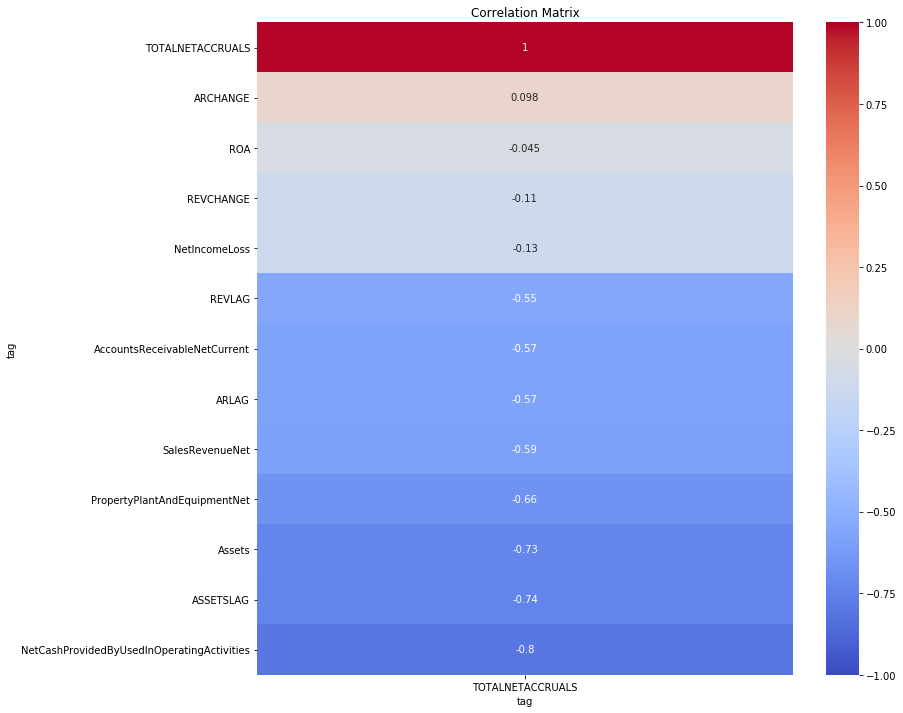

In [11]:
plt.figure(figsize= (12,12))
plt.title("Correlation Matrix")
sns.heatmap(df.corr()[['TOTALNETACCRUALS']].sort_values('TOTALNETACCRUALS', ascending = False), 
            annot = True, cmap = "coolwarm", vmax = 1, vmin = -1)

Text(0.5, 0, 'Accruals($)')

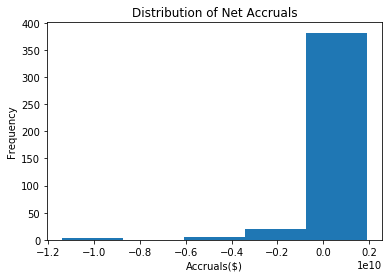

In [12]:
ax = df['TOTALNETACCRUALS'].plot(kind = 'hist', title = "Distribution of Net Accruals"
                           , y = "Frequency(units)", bins = 5)

ax.set_xlabel("Accruals($)")

In [13]:
df['TOTALNETACCRUALS'] = df['TOTALNETACCRUALS'].abs()

Text(0.5, 0, 'Log of Net Accruals($)')

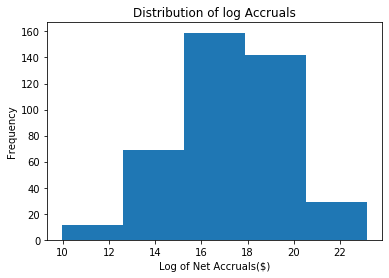

In [14]:
df['TotalAccrualslog'] = df['TOTALNETACCRUALS'].apply(np.log)

ax= df['TotalAccrualslog'].plot(kind = 'hist', title = "Distribution of log Accruals",bins = 5)

ax.set_xlabel("Log of Net Accruals($)")

In [15]:
all_nan_values = df.isnull().sum()[df.isnull().sum()  > 0].sort_values(ascending = False)

### Train Test Model

TNA / ATA = β0 + β1(1/ATA) + β2(ΔSales – ΔRec / ATA) + β3(GPPE / ATA ) + ε TNA= Total net accruals NOA= Net operating accruals ATA = Average total assets ΔSales = Change in sales ΔRec= Change in accounts receivable GPPE = Gross PP&E

In [535]:
features = ['ASSETSLAG','REVCHANGE' , 
            'ARCHANGE',   'PropertyPlantAndEquipmentNet', 'NetCashProvidedByUsedInOperatingActivities',
           'NetIncomeLoss']

In [536]:
poly = PolynomialFeatures(include_bias=False)

In [537]:
X_poly = poly.fit_transform(df[features])

In [538]:

df_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(features))

In [539]:
X = df_poly
y = df['TotalAccrualslog']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30,
                                                    random_state = 35)




In [540]:
from sklearn.dummy import DummyRegressor
dummy = DummyRegressor(strategy = "mean")
dummy.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

### Linear  Model 1



In [541]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [542]:
pred_train = lr.predict(X_train) 
                                      
pred_test = lr.predict(X_test)   

# Score it and round to 3 dp
print("Training Set R^2 Score is:", np.round(lr.score(X_train, y_train),3))
print("Testing Set R^2 Score is:", np.round(lr.score(X_test, y_test),3))

Training Set R^2 Score is: 0.562
Testing Set R^2 Score is: -38.877


Coeficients and stats model

In [543]:
model_accruals = linear_model.LinearRegression(fit_intercept = True)
TotalNetAccruals = df['TOTALNETACCRUALS']
x = df[features]
x_constant = sm.add_constant(x)
model_accruals = sm.OLS(TotalNetAccruals, x_constant).fit()
model_accruals.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       TOTALNETACCRUALS   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1661.
Date:                Wed, 04 Mar 2020   Prob (F-statistic):          1.23e-280
Time:                        16:34:37   Log-Likelihood:                -8452.5
No. Observations:                 410   AIC:                         1.692e+04
Df Residuals:                     403   BIC:                         1.695e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                       1.612e+07   1.17e+07      1.375      0.170   -6.93e+06    3.92e+07
ASSETSLAG                                      0.0147      0.003      5.261      0.000       0.009       0.020
REVCHANGE                                      0.0521      0.017      3.158      0.002       0.020       0.085
ARCHANGE                                      -0.1433      0.100     -1.434      0.152      -0.340       0.053
PropertyPlantAndEquipmentNet                  -0.0073      0.004     -1.931      0.054      -0.015       0.000
NetCashProvidedByUsedInOperatingActivities     0.8863      0.017     52.757      0.000       0.853       0.919
NetIncomeLoss                                 -0.8871      0.021    -42.664      0.000      -0.928      -0.846
==============================================================================
Omnibus:                      729.168   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           369334.811
Skew:                          10.788   Prob(JB):                         0.00
Kurtosis:                     148.444   Cond. No.                     1.34e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

I created the regression model based off the 2016 period and the 2015 prior period. We trained this model to find a goodness of fit and coefficients to show the relationships between total accruals to the 5 variables used in both models.

2016 actual model analysis: We use a Regression Analysis to see how closley related independent variables are to dependent variables. "The result of pulling discretionary accrual amounts from the total accrual amount is a metric that reflects accruals that are due to management's choices alone; in other words, there appears to be no business reason for these accruals. So, discretionary accruals are a better proxy for earnings quality." We want to predict total net accruals(non discretionary) for companies based off certain independent variables. To estimate non discretionary accrual amounts, we use a time series analysis. We look at data over a period of time. This model is created based off the 2016 period and the lagged variables are the prior period. An error term is a variable that shows a misrepresentation in the relationship between the independent and dependent variable. An error term in this case is represeneted by discretionary accruals. The higher the discretionary accruals the lower the quality of earnings. Inputs Variables: Dependent Variables: Total NET ACCRUALS The Dependent variable is the variable that is being tested. We are creating our model based of 55 observations in 2016 Independent Variables: Prior Year Assets Prior Year Revenue PRIOR YEAR AR Change In Revenue Change In Accounts REC Return on Assets

As you can see from above we use lag variables to find the prior year assets

Results

Created a regression model to test total net accruals, based off 5 variables; Prior Year Assets, Prior Year Revenue, Change in Revenue, Change in REC, and change in assets. We want to use this model to predict total net accruals for firms and check the error rate to see managements decisions on accruals. The R squared value in this model is .944. R squared is the fraction of variation in your predicted variable in relation to your independent variable. That means that the closer the model is to 100%, explains that all the variablity is around the average. Based off these 55 observations, the model shows that 94.4 percent of the data is around the mean. As you see from, the predictions based off the model shows that the predicted total net accruals are closley related to the actual net accruals. Regression coefficients represents the mean change in the response variable for one unit of change in the independent variable. Change in AR has a coefficient of 7.5939, which indicates that for every additional Recieavable you can expect Total NET ACCRUALS to increase by an average of 7.5939 dollars.

COMPARISION:

We used the prior period to to test the regression model. I imported data from 2016 to get more observations for my regression model. I thought it would be better to train the actual model with over 410 observations.

Goodness of Fit:

A model fits the data if the models observed values and the models predicted values. As you can see from the r squared, of .662, that the explained variation/total variation is approx 66.2 percent. The actual model had 55 observations, which could be an explanation behind the 94.4% r squared value. The closer to 100%, the less variation in the model. As you can see from the predicted observations from above, I compared the first 4 of the predicted observations to the actual observations to see the realibility of the model. The first 4 predicted net accrual amount are:

You can see there are variations between the predicted observations and actual observations, but thats due to the fact that the model only explains 64.4% of the variations.


The first observation that I found is the return on assets coefficient value. The value is so small that it shows a little to no relationship between return on assets and total net accruals. To get a better r squared value I would reccomend dropping the return on assets coefficient.

The second observation that I found is the signifcance of the p values in both models. The higher the p value, represents the changes in the predictor is not responsive. The common alpha value is .05 and if it is greater than .05 indicates that the variable is not statistically significant. A predictor that has a low p value represents greater responsivness between changes in the tested variable. As you can see from the model, there were significant changes in p values in prior year assets, and prior year revenue from the actual model to the trained model. Prior year assets represents a significant variable in the trained model and not a significant variable in the actual model. Return on assets shows no responsivness which means that we could ommit this variable for a better model. Change in Revenue and AR showed perfect responsivness to total accruals and should be used predict the model.

Based off the p values and the change in r squared I decided to make some changes to the model for further testing. I will test total net accruals based off the variables that have low p values. The new regression model is going to ommit return on assets, the constant, and prior year AR. I decided to keep the coefficient for prior year revenue because of the low p value in the trained model. The model is going to be used to test future net accruals in the 2017 quarter 3 periods. We are going to look at if the predicted values are too high, too low, or equal to the actual observations.

### Model 3: Ridge Model

In [544]:
r_alphas = np.logspace(0, 5, 100)
# Generates 100 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.

# Cross-validate over our list of ridge alphas.
ridge_model = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

# Fit model using best ridge alpha!
ridge_model = ridge_model.fit(X_train, y_train)

In [545]:
ridge_model.alpha_

19630.406500402725

In [546]:
print("Train Set R^2 Score is:", ridge_model.score(X_train, y_train))
print("Testing Set R^2 Score is:", ridge_model.score(X_test, y_test))

Train Set R^2 Score is: 0.5615183327053754
Testing Set R^2 Score is: -38.87769727852582


In [547]:
ridge_model.coef_

array([ 5.04618014e-10, -2.59552007e-10, -1.69084012e-10, -2.83479493e-10,
        2.05106005e-09, -2.62958692e-09, -1.48496315e-20, -1.47231017e-21,
        4.90097420e-19, -8.22773924e-21,  5.86292677e-20, -1.97672889e-21,
        1.05780936e-18, -1.52126974e-17,  2.54269270e-19, -1.09030196e-18,
        8.79937904e-20,  4.65444714e-17, -7.13334153e-19,  5.93184083e-18,
       -8.20552888e-18,  1.27358145e-20,  6.51721258e-20,  5.26512315e-20,
       -3.69179485e-19,  1.84699793e-19,  7.39090596e-19])

In [548]:
best_features = [tup for tup in list(zip(ridge_model.coef_,X_test.columns)) if tup[0] != 0]
best_features.sort(reverse=False) #descending order
best_features

[(-2.629586915838737e-09, 'NetIncomeLoss'),
 (-2.834794932053194e-10, 'PropertyPlantAndEquipmentNet'),
 (-2.595520065845338e-10, 'REVCHANGE'),
 (-1.690840123450012e-10, 'ARCHANGE'),
 (-1.5212697411229935e-17, 'REVCHANGE ARCHANGE'),
 (-8.205528881829285e-18, 'ARCHANGE NetIncomeLoss'),
 (-1.0903019638343728e-18,
  'REVCHANGE NetCashProvidedByUsedInOperatingActivities'),
 (-7.133341534853538e-19, 'ARCHANGE PropertyPlantAndEquipmentNet'),
 (-3.6917948466604774e-19, 'NetCashProvidedByUsedInOperatingActivities^2'),
 (-1.4849631461475682e-20, 'ASSETSLAG^2'),
 (-8.22773924378817e-21, 'ASSETSLAG PropertyPlantAndEquipmentNet'),
 (-1.9767288908084723e-21, 'ASSETSLAG NetIncomeLoss'),
 (-1.4723101708456572e-21, 'ASSETSLAG REVCHANGE'),
 (1.273581446545447e-20, 'PropertyPlantAndEquipmentNet^2'),
 (5.265123145046633e-20, 'PropertyPlantAndEquipmentNet NetIncomeLoss'),
 (5.862926767836521e-20,
  'ASSETSLAG NetCashProvidedByUsedInOperatingActivities'),
 (6.517212579482264e-20,
  'PropertyPlantAndEquipmen

## KNN Regressor

In [552]:
pipe_knn = Pipeline([
    ('sc', StandardScaler(with_mean = False)),
    ('model', KNeighborsRegressor())
])

knn_params = {
    'model__n_neighbors': range(1,10),
    'model__metric': ['minkowski', 'Euclidean', 'DistanceMetric']
}

In [553]:
pipe_knn_gridsearch = GridSearchCV(pipe_knn,
                                knn_params ,
                                cv = 5,
                                scoring='r2',
                                verbose=1)

In [554]:
results_knn = pipe_knn_gridsearch.fit(X_train, y_train);

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    0.5s finished


In [555]:
pipe_knn_gridsearch.best_params_

{'model__metric': 'minkowski', 'model__n_neighbors': 5}

In [556]:
train_score = pipe_knn_gridsearch.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(train_score))
test_score = pipe_knn_gridsearch.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN set accuracy: 0.7593
Best TEST set accuracy: 0.7109


## Decision Tree

In [557]:
pipe_dt = Pipeline([
    ('sc', StandardScaler(with_mean = False)),
    ('model', DecisionTreeRegressor())
])

dt_params = {
   'model__max_depth': [1,3,10,20],
   'model__max_features' :[1,3,5,6,7,8,9,10.15,15,20]
}

In [558]:
pipe_dt_gridsearch = GridSearchCV(pipe_dt,
                                dt_params ,
                                cv = 5,
                                scoring='r2',
                                verbose=1)

In [559]:
results_decision = pipe_dt_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished


In [560]:
train_score_dec = results_decision.best_score_
print('Best TRAIN accuracy: {:.4f}'.format(train_score_dec))
test_score_dec = results_decision.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score_dec))

Best TRAIN accuracy: 0.7225
Best TEST set accuracy: 0.5649


## Bagged Decision Tree¶

In [561]:
pipe_bg = Pipeline([
    ('sc', StandardScaler(with_mean = False)),
    ('model', BaggingRegressor())
])

bg_params = {
   'model__n_estimators': range(10, 100, 10),
}

pipe_bg_gridsearch = GridSearchCV(pipe_bg,
                                bg_params ,
                                cv = 5,
                                scoring='r2',
                                verbose=1)

In [562]:
results_bagging = pipe_bg_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    5.6s finished


In [563]:
train_score_bag = results_bagging.best_score_
print('Best TRAIN accuracy: {:.4f}'.format(train_score_bag))
test_score_bag = results_bagging.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score_bag))

Best TRAIN accuracy: 0.8172
Best TEST set accuracy: 0.8047


## Random Forests¶

In [564]:
pipe_rf = Pipeline(steps = [ ('sc', StandardScaler()),
                          ('rf', RandomForestRegressor())
                         
                        ])    

# Construct Grid Parameters
hyperparams = {
               
               
                                                        # use a single value that isn't built into
                                                        # the defaults (otw: stopwords left in
               'rf__n_estimators': [100, 150, 200],
               'rf__max_depth': [None, 1, 2, 3, 4, 5],
}
                
              

 # Perform Grid Search
gs_rf = GridSearchCV(pipe_rf, # pipeline object replaces what we usually had as empty model class
                 param_grid=hyperparams,
                 cv = 5,
                 scoring = 'r2')


In [565]:
results_rf= gs_rf.fit(X_train, y_train)

In [566]:
train_score_rf = results_rf.best_score_
print('Best TRAIN accuracy: {:.4f}'.format(train_score_rf))
test_score_rf = results_rf.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score_rf))

Best TRAIN accuracy: 0.8122
Best TEST set accuracy: 0.8070


## Ada Boost Model

In [567]:
pipe_ab = Pipeline(steps = [ ('sc', StandardScaler()),
                         ('ab',AdaBoostRegressor(base_estimator=DecisionTreeRegressor()))
                         
                        ])    

# Construct Grid Parameters
hyperparams = {
               
               
                                                        # use a single value that isn't built into
                                                        # the defaults (otw: stopwords left in
               'ab__n_estimators': [50,100],
               'ab__base_estimator__max_depth': [1,2],
               'ab__learning_rate': [.9, 1.]
}
                
              

 # Perform Grid Search
gs_ab = GridSearchCV(pipe_ab, # pipeline object replaces what we usually had as empty model class
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'r2')


In [568]:
results_ab = gs_ab.fit(X_train, y_train)
train_score_ab = results_ab.best_score_
print('Best TRAIN accuracy: {:.4f}'.format(train_score_ab))
test_score_ab = results_ab.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score_ab))


Best TRAIN accuracy: 0.7267
Best TEST set accuracy: 0.6709


## Support Vector Machine¶

In [569]:
svr = svm.SVR()
svr.fit(X_train, y_train)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [570]:
pipe_svm = Pipeline([
    ('sc', StandardScaler(with_mean = False)),
    ('model', svm.SVR())
])

svm_params = {
   'model__C': [1,3,10,100],
   'model__epsilon' : range(0,1)
}

gs_svm = GridSearchCV(pipe_svm, # pipeline object replaces what we usually had as empty model class
                 param_grid=svm_params,
                 cv = 3,
                 scoring = 'r2')

In [571]:
results_svm = gs_svm.fit(X, y)
train_score_svm = results_svm.best_score_
print('Best TRAIN accuracy: {:.4f}'.format(train_score_svm))
test_score_svm = results_ab.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score_svm))

Best TRAIN accuracy: 0.4752
Best TEST set accuracy: 0.6709


## Model Selection

|Model|Type|Train R2|Testing R2|
|---|---|---|---|
|**Model 1**|*Linear*|.84|.84| 
|**Model 2**|*Linear*|.93|.94|
|**Model 3**|*Ridge*|.91|.88|
|**Model 4**|*Lasso*|.91|.88|




Based on R2 scores listed above,  and residual plots, I have decided to choose model 2 to deliver to our clients in predicting sales prices, and capital gains at year end. This model will be best suited for our clients to prepare for year end tax planning in the aftermath of Tax cut and job act in which Trump issued. Model 2 does the best in predicting high sales prices, and more of the variance in the data can be explained by our model. We want to deliver high level tax solutions to our clients with the least amount of residuals.

## Validate Predictions on 2017 Q3 DataSet


In [572]:
num4 =  pd.read_csv('./data/2017q3/num.txt', sep = '\t', encoding="latin-1")
tag4 =  pd.read_csv('./data/2017q3/tag.txt', sep = '\t', encoding="latin-1")
pre4 =  pd.read_csv('./data/2017q3/pre.txt', sep = '\t', encoding="latin-1")
sub4 =  pd.read_csv('./data/2017q3/sub.txt', sep = '\t', encoding="latin-1")

In [573]:
firstmerge4 = pd.merge(pre4, sub4, how = "left", on=['adsh'])   #left merge

secondmerge4 = pd.merge(firstmerge4, tag4, how= "inner", on =['tag', 'version'])

thirdmerge4 = pd.merge(secondmerge4, num4, how = "inner", on =['adsh', 'tag', 'version'])
sec_data2017 = thirdmerge4[['cik','adsh' , 'afs' , 'qtrs' , 'fy' , 'fp', 'tag', 'version', 'value' , 'ddate']].sort_values(['cik'])
sec_data2017

,cik,adsh,afs,qtrs,fy,fp,tag,version,value,ddate
158530,1750,0001047469-17-004528,1-LAF,0,2017.000,FY,DeferredTaxLiabilitiesNoncurrent,us-gaap/2016,37200000.000,20170531
73518,1750,0001104659-17-058003,1-LAF,0,2018.000,Q1,CashAndCashEquivalentsAtCarryingValue,us-gaap/2016,7900000.000,20160831
73517,1750,0001104659-17-058003,1-LAF,0,2018.000,Q1,CashAndCashEquivalentsAtCarryingValue,us-gaap/2016,31200000.000,20160531
73516,1750,0001104659-17-058003,1-LAF,0,2018.000,Q1,CashAndCashEquivalentsAtCarryingValue,us-gaap/2016,15100000.000,20170831
73515,1750,0001104659-17-058003,1-LAF,0,2018.000,Q1,CashAndCashEquivalentsAtCarryingValue,us-gaap/2016,10300000.000,20170531
...,...,...,...,...,...,...,...,...,...,...
1504508,1712041,0001615774-17-004906,5-SML,2,2017.000,Q2,RepaymentsOfNotesPayable,us-gaap/2017,2544.000,20170630
1504509,1712041,0001615774-17-004906,5-SML,4,2017.000,Q2,RepaymentsOfNotesPayable,us-gaap/2017,54772.000,20161231
1504510,1712041,0001615774-17-004906,5-SML,4,2017.000,Q2,RepaymentsOfNotesPayable,us-gaap/2017,nan,20151231
982100,1712041,0001615774-17-004906,5-SML,2,2017.000,Q2,GeneralAndAdministrativeExpense,us-gaap/2017,47068.000,20160630


In [574]:
Regression_2017 =  sec_data2017[(sec_data2017.tag == 'NetIncomeLoss')
                        | (sec_data2017.tag == 'NetCashProvidedByUsedInOperatingActivities')
                        | (sec_data2017.tag == 'SalesRevenueNet')
                        | (sec_data2017.tag == 'Assets')
                        | (sec_data2017.tag == 'AccountsReceivableNetCurrent')
                        | (sec_data2017.tag == 'PropertyPlantAndEquipmentNet')]
Regression_2017

,cik,adsh,afs,qtrs,fy,fp,tag,version,value,ddate
44008,1750,0001047469-17-004528,1-LAF,0,2017.000,FY,Assets,us-gaap/2016,1454100000.000,20150531
43430,1750,0001104659-17-058003,1-LAF,0,2018.000,Q1,Assets,us-gaap/2016,1531700000.000,20170831
44010,1750,0001047469-17-004528,1-LAF,0,2017.000,FY,Assets,us-gaap/2016,1504100000.000,20170531
44009,1750,0001047469-17-004528,1-LAF,0,2017.000,FY,Assets,us-gaap/2016,1456000000.000,20160531
43429,1750,0001104659-17-058003,1-LAF,0,2018.000,Q1,Assets,us-gaap/2016,1504100000.000,20170531
...,...,...,...,...,...,...,...,...,...,...
1243734,1712041,0001615774-17-004906,5-SML,4,2017.000,Q2,NetIncomeLoss,us-gaap/2017,-338484.000,20161231
1243733,1712041,0001615774-17-004906,5-SML,2,2017.000,Q2,NetIncomeLoss,us-gaap/2017,-1338076.000,20170630
1486352,1712041,0001615774-17-004906,5-SML,0,2017.000,Q2,PropertyPlantAndEquipmentNet,us-gaap/2017,1942.000,20170630
1486351,1712041,0001615774-17-004906,5-SML,0,2017.000,Q2,PropertyPlantAndEquipmentNet,us-gaap/2017,2910.000,20151231


In [575]:

Q3 = Regression_2017[(Regression_2017.ddate == 20170630)
                   | (Regression_2017.ddate == 20160630)]

Q317 = pd.pivot_table(Q3,
                             values = 'value',
                             index = ['cik','ddate'],
                             columns = 'tag',
                             dropna = True)
Q317['TOTALNETACCRUALS'] =  Q317['NetIncomeLoss'] - Q317['NetCashProvidedByUsedInOperatingActivities']
Q317.dropna(axis=0)

Q317['ASSETSLAG']=Q317.groupby('cik').Assets.shift()
Q317['REVLAG'] = Q317.groupby('cik').SalesRevenueNet.shift()
Q317['ARLAG'] = Q317.groupby('cik').AccountsReceivableNetCurrent.shift()
Q317['REVCHANGE'] = Q317['SalesRevenueNet'] - Q317['REVLAG']
Q317['ARCHANGE'] = Q317['AccountsReceivableNetCurrent'] - Q317['ARLAG']
Q317['ROA'] = Q317['NetIncomeLoss'] / Q317['Assets']
Regression_Q317 = Q317.dropna(axis = 0)
Regression_Q317

,tag,AccountsReceivableNetCurrent,Assets,NetCashProvidedByUsedInOperatingActivities,NetIncomeLoss,PropertyPlantAndEquipmentNet,SalesRevenueNet,TOTALNETACCRUALS,ASSETSLAG,REVLAG,ARLAG,REVCHANGE,ARCHANGE,ROA
cik,ddate,,,,,,,,,,,,,
8670,20170630,1703600000.000,37180000000.000,2125900000.000,999600000.000,779900000.000,8518100000.000,-1126300000.000,43670000000.000,8234000000.000,1742800000.000,284100000.000,-39200000.000,0.027
14195,20170630,230011000.000,1450979000.000,90344000.000,56650000.000,364880000.000,1786103000.000,-33694000.000,1456667000.000,1808778000.000,191678000.000,-22675000.000,38333000.000,0.039
37472,20170630,42362000.000,270045000.000,26388000.000,14903500.000,70661000.000,293099000.000,-11484500.000,246896000.000,311435000.000,44618000.000,-18336000.000,-2256000.000,0.055
50471,20170630,4009127.000,45912476.000,2257138.000,3777532.000,2115277.000,18939263.000,1520394.000,38589892.000,14010693.000,3048774.000,4928570.000,960353.000,0.082
55242,20170630,380425000.000,2415496000.000,192202000.000,36890500.000,744388000.000,1311696500.000,-155311500.000,2362783000.000,1309830000.000,370916000.000,1866500.000,9509000.000,0.015
80424,20170630,4594000000.000,120406000000.000,12753000000.000,8770500000.000,19893000000.000,40568500000.000,-3982500000.000,127136000000.000,40700500000.000,4373000000.000,-132000000.000,221000000.000,0.073
89800,20170630,2377874000.000,20717398000.000,586133000.000,438687000.000,1889917000.000,5116510500.000,-147446000.000,6665677000.000,4506537000.000,1473078000.000,609973500.000,904796000.000,0.021
92679,20170630,45347000.000,217143000.000,31468000.000,1502000.000,34455000.000,250974000.000,-29966000.000,245998000.000,263164500.000,46759000.000,-12190500.000,-1412000.000,0.007
100548,20170630,69246000.000,2904532000.000,236601000.000,65392000.000,2174609000.000,457368500.000,-171209000.000,2697301000.000,400297500.000,59301000.000,57071000.000,9945000.000,0.023


In [576]:
features = ['ASSETSLAG','REVCHANGE' , 
            'ARCHANGE',   'PropertyPlantAndEquipmentNet', 'NetCashProvidedByUsedInOperatingActivities',
           'NetIncomeLoss'
           ]

In [577]:
poly = PolynomialFeatures(include_bias=False)

In [578]:
X_poly = poly.fit_transform(Regression_Q317[features])

In [579]:
df_poly_17 = pd.DataFrame(X_poly, columns=poly.get_feature_names(features))

In [594]:
bagging_val= results_bagging.best_estimator_.predict((df_poly_17))

bagging_val

array([21.0053593 , 17.09782494, 16.72343526, 14.17956789, 18.73148113,
       21.97364418, 20.31316355, 16.85987192, 18.77088841, 17.31904904,
       16.48104487, 18.03560612, 17.35330752, 19.91363019, 17.50438344,
       13.7900425 , 16.07621522, 18.67735827, 14.600149  , 14.41605388,
       15.80761784, 17.11295137, 16.69311874, 16.3065709 , 15.05844055,
       20.05891554, 16.39893316, 15.69626175, 14.93072296, 13.73188605,
       18.74380242, 16.62072765, 16.10004955, 17.20160934, 19.33094303,
       18.23229299, 12.09229628, 17.60917193, 15.04941668, 20.11642017,
       20.76507505, 15.33910971, 18.51460785, 17.45742947, 15.94195636,
       16.61861785, 16.25487863, 17.40336516, 20.35295144, 18.7479377 ,
       19.05880145, 18.66633066, 16.3056072 , 17.20073098])

In [595]:
df_val_bag = pd.DataFrame(np.exp(bagging_val), columns = ['Predicted2017Q3Accruals'])
df_val_bag['TotalAccruals'] = list(Regression_Q317['TOTALNETACCRUALS'])
df_val_bag['Variance'] = df_val_bag['Predicted2017Q3Accruals'] - df_val_bag['TotalAccruals']
df_val_bag['ExpectedAverage(%)'] = df_val_bag['Variance']/ df_val_bag['Predicted2017Q3Accruals']  * 100
df_val_bag.sort_values(by = 'Variance', ascending = True)

,Predicted2017Q3Accruals,TotalAccruals,Variance,ExpectedAverage(%)
10,14375628.500,219016500.000,-204640871.500,-1423.526
35,82829347.145,193748000.000,-110918652.855,-133.912
22,17771715.621,119450000.000,-101678284.379,-572.135
9,33232837.852,120656000.000,-87423162.148,-263.063
32,9821157.571,28962000.000,-19140842.429,-194.894
43,38165001.946,49324500.000,-11159498.054,-29.240
47,36156422.827,47056000.000,-10899577.173,-30.146
28,3050215.988,5966500.000,-2916284.012,-95.609
3,1439156.725,1520394.000,-81237.275,-5.645
19,1823109.061,1849000.000,-25890.939,-1.420


In [592]:
high_variance = df_val_bag[(df_val_bag['ExpectedAverage(%)'] < -40)]
print('Percentages lower than -40% of the data' , len(high_variance))

Percentages lower than -40% of the data 6


In [597]:
rf_val= results_rf.best_estimator_.predict((df_poly_17))

rf_val

array([20.87583617, 17.30349714, 16.72747755, 14.14068639, 18.73869594,
       22.13531639, 20.25454711, 16.78508956, 18.96082421, 17.20155589,
       16.77889614, 17.9414718 , 17.33613799, 19.96022139, 17.71817112,
       13.49408537, 16.34647789, 18.66751833, 14.57307815, 14.30859906,
       15.63349534, 17.27150711, 16.79720295, 16.35462285, 15.14195745,
       20.02450552, 16.58559131, 15.81144162, 14.79220154, 13.68568341,
       18.77079764, 16.40432534, 16.2868913 , 17.31399273, 19.31521186,
       18.46314493, 12.26532717, 17.50499167, 14.9638786 , 20.08615143,
       20.74810686, 15.27559139, 18.65777605, 17.5357113 , 16.05457603,
       16.69498423, 16.36743873, 17.41528212, 20.33448818, 18.82707159,
       19.09673083, 18.55395125, 16.19363518, 17.13010464])

In [598]:
df_val_rf = pd.DataFrame(np.exp(rf_val), columns = ['Predicted2017Q3Accruals'])
df_val_rf['TotalAccruals'] = list(Regression_Q317['TOTALNETACCRUALS'])
df_val_rf['Variance'] = df_val_rf['Predicted2017Q3Accruals'] - df_val_rf['TotalAccruals']
df_val_rf['ExpectedAverage(%)'] = df_val_rf['Variance']/ df_val_rf['Predicted2017Q3Accruals']  * 100
df_val_rf.sort_values(by = 'Variance', ascending = True)

,Predicted2017Q3Accruals,TotalAccruals,Variance,ExpectedAverage(%)
10,19363417.319,219016500.000,-199653082.681,-1031.084
22,19721164.378,119450000.000,-99728835.622,-505.694
9,29548864.807,120656000.000,-91107135.193,-308.327
35,104337869.085,193748000.000,-89410130.915,-85.693
32,11838781.934,28962000.000,-17123218.066,-144.637
47,36589874.976,47056000.000,-10466125.024,-28.604
43,41272678.357,49324500.000,-8051821.643,-19.509
28,2655654.084,5966500.000,-3310845.916,-124.672
19,1637365.422,1849000.000,-211634.578,-12.925
3,1384274.029,1520394.000,-136119.971,-9.833


I took the percentage of the varaince over the actual amounts to compare and see how close the percentage change is to 0. I took -40% as a threshold to see how many percentages fall below 40%. I found that 36 of the 54 of the observations fell below this threshold, which shows that over 70% of the data shows a high amount of variance. When there is a high level of variance in a model in the model, it shows that new variables should be implemented to better test total accruals. I also ran a regression model on the 2017 Q3 data to see how responsive variables are relative to tested variables. R squared value of .660 shows the model has a good amount of variance, which shows that our actual tested variable has deviations from any predictions made in the future.

In conclusion, the jones model is a way for companies to predict non discretionary accruals across firms using time series data. Being able to extract industry wide financial data, and predict future companys amounts based off multiple regression. We want to be able to find relationships between relationships, and create models to help conclude on hypothesis and test variables that are in interest of management. If I were to work for a big bank, I could use financial data for individual customers to predict uncollectibles and write off credit based off prior data. Although, our model has a lot of variance, that comes to show that we have to continue to find new variables to test to find the least amount of variance. We can look at p values that are lower than .05 which will show the level of responsivness for certain variables. We saw, on average, that the change in revenues and change in accounts recievables have the biggest effect on the change in accruals. We see in many fraud cases, that trends in recievables and sales can be examined to see any overstatements in receivables and revenue. In the next model, I want to add non cash financing activites, like depreciation, as variables into the model to see if there is any relationship to accruals. Many companies have different ways to identify tags in the database, so it is useful to extract data from the sec taxonomy to see the most frequent tags used in the industry. This will allow us analysts to find more relationships in accruals across the industry

## Model Evaluation

##### Pipeline Logistic Regression(Model 3)

#### I will use 5 evaluation tools to dive deeper into the model I selected

1)Models Best Paramaters

2)Testing Accuracy Score

3)Confusion Matrix

4)Coeficients

5)ROC Curve


## Conclusion

To conclude, after examining both the nba and nfl subreddits we found that the logistic regression model properly classifies titles into nba and nfl with 89% accuracy. As you can see from our confusion matrix, we are able to classify true values(nba and nfl) 89% of the time, with only 11% of those values missclassified. We are confident that this model will be able to properly classify nba/nfl espn blogs 90% of the time. This will allow us to properly deploy marketing strategies toward nba fans on the espn blogs. While examining the coeficients, maybe I should remove nba and nfl from title to avoid leakage in the model. Although I am using the model to predict on espn blogs, I decided to keep those 2 words because they are frequently used across different blogs


## Recommendations

At first, we used just the plain title to classify subreddits. This gave me a .88 score, but after I changed it to all lower case words I was able to get a slightlty better score. For example, if the reddit title had LeBron, or Lebron, it was used as different features, rather than the same features. This is why lowercase makes it easier to predict on other posts. To further our analysis, we would want to be able to gather all sports subreddits and be able to properly classify all sports subreddits. We are limited by the population of nfl and nba, and using the espn nba/nfl blog will give us some insight on nba fans but we would like to examine the full sports espn blog. This will help us target advertisements on the sports blogs on not only espn but all sorts of media outlets. 